In [12]:
# packages and preferences
import pyreadr
import numpy as np 
import pandas as pd
import re 
from itertools import chain # flatten lists
from datetime import datetime

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# gof
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

In [2]:
trend_df_sort = pd.read_csv("/Users/david/Documents/david/karriere/projects/predict trends case law/case_law_trends.csv")

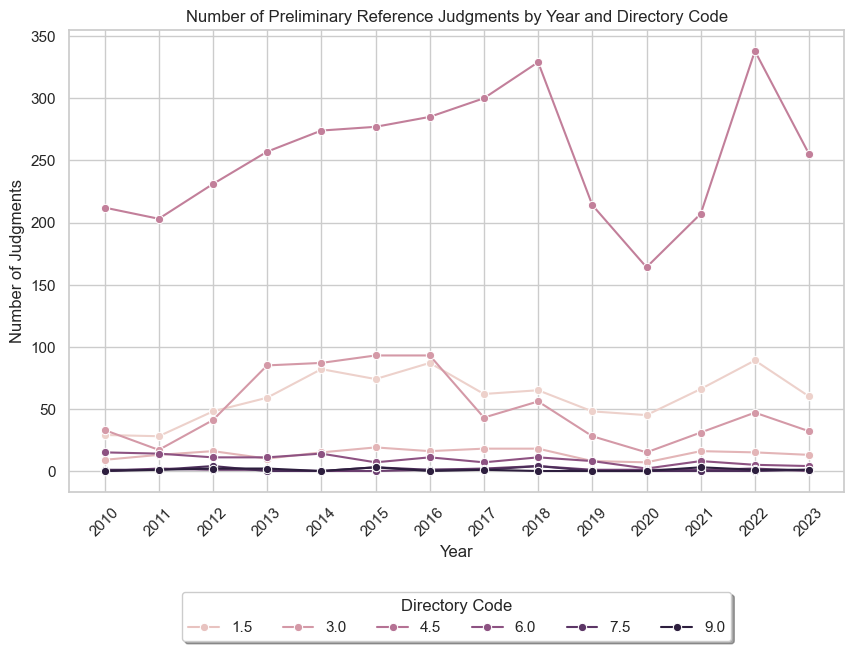

In [4]:
# plot trends by dircode

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot trend lines
sns.lineplot(x='year_judgment', y='count', hue='dircode', data=trend_df_sort, marker='o')

plt.title('Number of Preliminary Reference Judgments by Year and Directory Code')
plt.xticks(trend_df_sort['year_judgment'].unique(), rotation=45)
plt.xlabel('Year')
plt.ylabel('Number of Judgments')
plt.legend(title='Directory Code', loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=8)
plt.show()

For OLS

In [5]:
trend_df_sort_ols = trend_df_sort
dircode_dummies = pd.get_dummies(trend_df_sort_ols["dircode"], prefix='dircode', drop_first=True).astype(int)
trend_df_sort_ols = pd.concat([trend_df_sort_ols, dircode_dummies], axis=1)
trend_df_sort_ols

,Unnamed: 0,year_judgment,dircode,count,dircode_2.0,dircode_3.0,dircode_4.0,dircode_6.0,dircode_7.0,dircode_8.0,dircode_9.0
0,0,2010,1.0,29,0,0,0,0,0,0,0
1,1,2011,1.0,28,0,0,0,0,0,0,0
2,2,2012,1.0,48,0,0,0,0,0,0,0
3,3,2013,1.0,59,0,0,0,0,0,0,0
4,4,2014,1.0,82,0,0,0,0,0,0,0
5,5,2015,1.0,74,0,0,0,0,0,0,0
6,6,2016,1.0,87,0,0,0,0,0,0,0
7,7,2017,1.0,62,0,0,0,0,0,0,0
8,8,2018,1.0,65,0,0,0,0,0,0,0
9,9,2019,1.0,48,0,0,0,0,0,0,0


In [6]:
# for n prediction steps, treat incremental prediction as data and incorporate it into main train dataset
    
last_year_in_data = np.max(trend_df_sort["year_judgment"])

prediction_steps = 3

for step in reversed(range(1,prediction_steps+1)) :

    # dv lags
    trend_df_sort_ols['count_l1'] = trend_df_sort_ols.groupby(['dircode'])['count'].shift()
    trend_df_sort_ols['count_l2'] = trend_df_sort_ols.groupby(['dircode'])['count_l1'].shift()
    trend_df_sort_ols['count_l3'] = trend_df_sort_ols.groupby(['dircode'])['count_l2'].shift()
    trend_df_sort_ols['count_l4'] = trend_df_sort_ols.groupby(['dircode'])['count_l3'].shift()
    trend_df_sort_ols['count_l5'] = trend_df_sort_ols.groupby(['dircode'])['count_l4'].shift()

    #print("Data set dims:", trend_df_sort_ols.shape)

    # distinguish between trade and prediction set based on year cutoff
    last_year_in_train_data = last_year_in_data - step
    prediction_year = last_year_in_train_data + 1
    print("Year: ", last_year_in_train_data)
    trend_df_sort_ols_train = trend_df_sort_ols.loc[(trend_df_sort_ols["year_judgment"] <= last_year_in_train_data)]
    trend_df_sort_ols_pred = trend_df_sort_ols.loc[(trend_df_sort_ols["year_judgment"] == (last_year_in_train_data + 1))]
       
    trend_df_sort_ols_train.dropna(inplace=True)
    #trend_df_sort_ols_train.drop("dircode", axis=1, inplace=True)
    #trend_df_sort_ols_pred.drop("dircode", axis=1, inplace=True)

    # X and y 
    y_train = trend_df_sort_ols_train['count']

    selected_columns = ['year_judgment']
    selected_columns.extend([col for col in trend_df_sort_ols_train.columns if col.startswith('dircode_')])
    selected_columns.extend([col for col in trend_df_sort_ols_train.columns if col.startswith('count_l')])
    X_train = sm.add_constant(trend_df_sort_ols_train[selected_columns])
    print("Train set dims:", X_train.shape)
    X_train_np = np.asarray(X_train, dtype=np.float64)



    # Train the model using the training sets

    lm1 = LinearRegression()
    lm1.fit(X_train, y_train)
    #print("Coefficients: \n", lm1.coef_)

    # gof
    preds_train = lm1.predict(X_train)
    print("Mean squared error: %.2f" % mean_squared_error(trend_df_sort_ols_train['count'], preds_train))
    print("Coefficient of determination: %.2f" % r2_score(trend_df_sort_ols_train['count'], preds_train))

    lm2 = sm.OLS(y_train, X_train_np).fit()
    #print(lm2.summary())


    # predictions
    trend_df_sort_ols_pred = trend_df_sort_ols_pred.drop("count", axis=1)
    trend_df_sort_ols_pred.reset_index(drop = True, inplace = True)
    X_pred = trend_df_sort_ols_pred.copy() # transformations applied to X_pred will not affect trend_df_sort_ols_pred
    X_pred["const"] = 1.0
    X_pred = X_pred[list(X_train.columns)] # reorder
    print("Pred set dims:", X_pred.shape)

    predictions = lm2.predict(np.asarray(X_pred, dtype=np.float64))
    print(predictions)
    predictions[predictions  < 0] = 0

    # insert y_hats
    trend_df_sort_ols_pred["count"] = predictions 

    # plug in predictions as observed data
    trend_df_sort_ols = trend_df_sort_ols.loc[trend_df_sort_ols["year_judgment"] != prediction_year]
    trend_df_sort_ols = pd.concat([trend_df_sort_ols, trend_df_sort_ols_pred], axis=0)
    trend_df_sort_ols.reset_index(drop = True, inplace = True)




# Even better: incorporate uncertainty (TODO): get_prediction method from the statsmodels library to calculate prediction intervals.
    

Year:  2020
Train set dims: (48, 14)
Mean squared error: 241.23
Coefficient of determination: 0.97
Pred set dims: (8, 14)
[ 34.55372664   8.10941631  21.64155004 205.79641384   1.12831126
  -3.01434324  -2.63888577  -2.32979988]
Year:  2021
Train set dims: (56, 14)
Mean squared error: 223.26
Coefficient of determination: 0.97
Pred set dims: (8, 14)
[ 28.78447206   3.08705681   8.9324446  182.91058735  -3.53408623
  -5.69793416  -5.87989227  -5.48007541]
Year:  2022
Train set dims: (64, 14)
Mean squared error: 213.68
Coefficient of determination: 0.97
Pred set dims: (8, 14)
[ 24.31223668   0.39101209   1.69775998 169.98111686  -3.80396215
  -5.89770518  -6.15446418  -6.45975538]


/var/folders/3p/ynx9h1ws7mqfb01ljsgzgs600000gn/T/ipykernel_1859/515383852.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trend_df_sort_ols_train.dropna(inplace=True)
/var/folders/3p/ynx9h1ws7mqfb01ljsgzgs600000gn/T/ipykernel_1859/515383852.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trend_df_sort_ols_train.dropna(inplace=True)
/var/folders/3p/ynx9h1ws7mqfb01ljsgzgs600000gn/T/ipykernel_1859/515383852.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [7]:
trend_df_sort_ols["year_judgment"].value_counts()

year_judgment
2010    8
2011    8
2012    8
2013    8
2014    8
2015    8
2016    8
2017    8
2018    8
2019    8
2020    8
2021    8
2022    8
2023    8
Name: count, dtype: int64

In [8]:
trend_df_sort_ols.sort_values(["dircode","year_judgment"], inplace = True)
trend_df_sort_ols

,Unnamed: 0,year_judgment,dircode,count,dircode_2.0,dircode_3.0,dircode_4.0,dircode_6.0,dircode_7.0,dircode_8.0,dircode_9.0,count_l1,count_l2,count_l3,count_l4,count_l5
0,0,2010,1.0,29.000000,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1,1,2011,1.0,28.000000,0,0,0,0,0,0,0,29.000000,NaN,NaN,NaN,NaN
2,2,2012,1.0,48.000000,0,0,0,0,0,0,0,28.000000,29.0,NaN,NaN,NaN
3,3,2013,1.0,59.000000,0,0,0,0,0,0,0,48.000000,28.0,29.0,NaN,NaN
4,4,2014,1.0,82.000000,0,0,0,0,0,0,0,59.000000,48.0,28.0,29.0,NaN
5,5,2015,1.0,74.000000,0,0,0,0,0,0,0,82.000000,59.0,48.0,28.0,29.0
6,6,2016,1.0,87.000000,0,0,0,0,0,0,0,74.000000,82.0,59.0,48.0,28.0
7,7,2017,1.0,62.000000,0,0,0,0,0,0,0,87.000000,74.0,82.0,59.0,48.0
8,8,2018,1.0,65.000000,0,0,0,0,0,0,0,62.000000,87.0,74.0,82.0,59.0
9,9,2019,1.0,48.000000,0,0,0,0,0,0,0,65.000000,62.0,87.0,74.0,82.0


# Visualize predictions

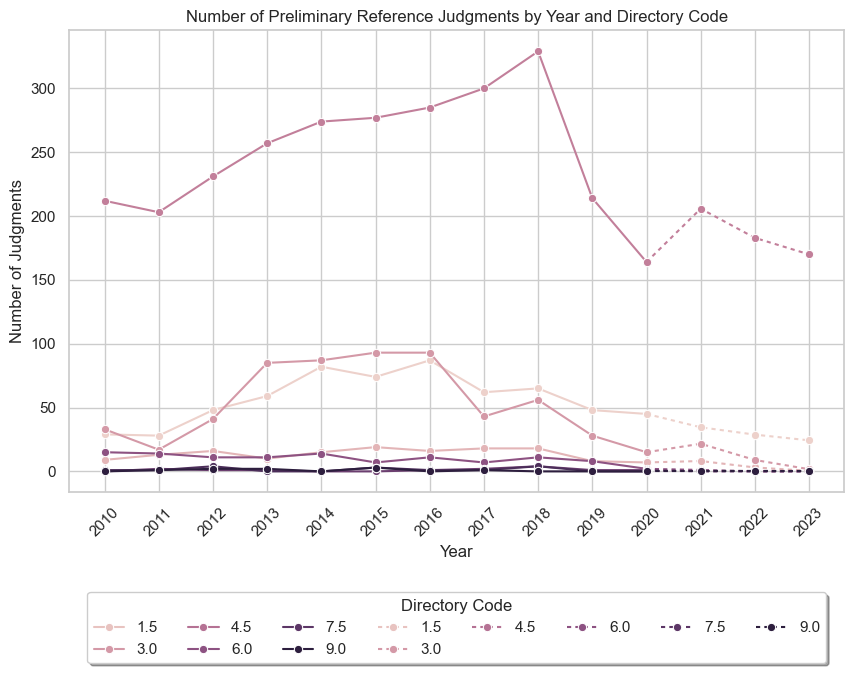

In [9]:
# plot trends by dircode

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# observed trend:
sns.lineplot(x='year_judgment', y='count', hue='dircode', data=trend_df_sort_ols.loc[trend_df_sort_ols["year_judgment"] <= (last_year_in_data - prediction_steps)], marker='o')
# predicted trend: 
sns.lineplot(x='year_judgment', y='count', hue='dircode', data=trend_df_sort_ols.loc[trend_df_sort_ols["year_judgment"] >= (last_year_in_data - prediction_steps)], marker='o', dashes=(2,2))

plt.title('Number of Preliminary Reference Judgments by Year and Directory Code')
plt.xticks(trend_df_sort['year_judgment'].unique(), rotation=45)
plt.xlabel('Year')
plt.ylabel('Number of Judgments')
plt.legend(title='Directory Code', loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=8)
plt.show()

In [14]:
# Prediction error

predictions = trend_df_sort_ols[["year_judgment","dircode","count"]].copy()
benchmark = trend_df_sort
predictions.rename(columns={"count": "count_estimated"}, inplace = True)
benchmark.rename(columns={"count": "count_actual"}, inplace = True)

compare_df = pd.merge(
    benchmark,
    predictions,
    how="left",
    on=["year_judgment","dircode"]
)

# correct for the fact that 2023 is not complete as of the date of scraping
input_date = "2023-11-16"
date_object = datetime.strptime(input_date, '%Y-%m-%d')
corrector_2023 = date_object.timetuple().tm_yday/365

error_2123 = np.sum(abs(compare_df.loc[compare_df["year_judgment"] >= 2021, "count_actual"]-compare_df.loc[compare_df["year_judgment"] >= 2021, "count_estimated"]))
error_2021 = np.sum(abs(compare_df.loc[compare_df["year_judgment"] == 2021, "count_actual"]-compare_df.loc[compare_df["year_judgment"] == 2021, "count_estimated"]))
error_2022 = np.sum(abs(compare_df.loc[compare_df["year_judgment"] == 2022, "count_actual"]-compare_df.loc[compare_df["year_judgment"] == 2022, "count_estimated"]))
error_2023 = np.sum(abs(compare_df.loc[compare_df["year_judgment"] == 2023, "count_actual"]/corrector_2023-compare_df.loc[compare_df["year_judgment"] == 2023, "count_estimated"]))

print("Error overall:", error_2123, "\n",
      "Error 2021:", error_2021, "\n",
      "Error 2022:", error_2022, "\n",
      "Error 2023:", error_2023, "\n")

Error overall: 503.6738954751503 
 Error 2021: 60.77058190031494 
 Error 2022: 273.28543918349544 
 Error 2023: 221.0866243913399 

